# DRL Homework 02
# Group 16

# PHOTOSENSITIVITY WARNING:
## Flashing images may appear on your screen when visualizing episodes. Take care!

In [1]:
import numpy as np
from os import system
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

## Task 01

### Maze generation

In [2]:
class Maze:
    """Generate mazes using the reverse backtracking algorithm"""
    def __init__(self, size):
        self.size = size
        # the maze is represented by a 2D-array
        # 1: wall, 0: path
        # initially, all tiles are set to 1
        self.tiles = [[1 for x in range(self.size)] for y in range(self.size)]
        self.tiles = np.array(self.tiles)

    # a method to set wall tiles to be path tiles
    # the maze is created by 'digging' through the walls
    def dig(self, x, y): 
        self.tiles[y][x] = 0
    
    # a method to check whether a tile has not been visited before by the maze generation algorithm
    def is_diggable(self, x, y):
        # check if (y,x) is in bounds
        if 0 <= x < self.size and 0 <= y < self.size:
            # if in bounds, has the tile not been visited before?
            return self.tiles[y][x] == 1 
        else:
            return False
    
    # the maze generation algorithm
    # a recursive method for digging paths 
    def dig_maze(self, x, y):
        # excavate the current position
        self.dig(x, y)
        
        # left, right, up, down
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        np.random.shuffle(directions)
        
        # in random order, check each direction...
        while len(directions) > 0:
            direction = directions.pop()
            target_x = x + (direction[0] * 2)
            target_y = y + (direction[1] * 2)
            # ... and if the target tile is a valid destination...
            if self.is_diggable(target_x, target_y):
                # ... dig a path to the target location
                self.dig(x + direction[0], y + direction[1])
                # recursion
                self.dig_maze(target_x, target_y)
        return self.tiles 

### Implementing a grid world

In [ ]:
class Gridworld:
    """Creates an environment for the agent to interact with"""
    def __init__(self, size, wide_paths = True):
        self.size = size
        self.is_wide = wide_paths
        # generate two mazes, one starting from the top left and one starting from the bottom right
        # then stick them together
        # 'size' needs to be an odd integer, otherwise the agent won't be able to reach the goal!
        self.grid = np.append(Maze(size).dig_maze(0,0),Maze(size).dig_maze(-0,-0), axis=1)
        # 
        if wide_paths:
            self.grid = np.repeat(np.repeat(self.grid,2,axis=0),2,axis=1)
        # place boundaries so that the agent doesn't escaoe
        self.grid = np.pad(self.grid, (1,1), 'constant', constant_values=(1,1))
        # create a list of all path tile coordinates
        self.paths = []
        for i in range(size+size*wide_paths):
            for j in range(size*2+(size*2)*wide_paths):
                if self.grid[i,j] == 0:
                    self.paths.append([i,j])
        
        # choose 10% percent of path tiles to be turned into special tiles
        sample = np.random.choice(len(self.paths),len(self.paths)//10, replace=False)
        # create a list of all special tile coordinates
        self.special_paths = [self.paths[x] for x in sample]
        # set path tiles to special tiles
        for i in self.special_paths:
            special_x = i[0]
            special_y = i[1]
            self.grid[special_x, special_y] = 2
                
        # define start position as top-left corner
        self.start = (1,1)
        self.y, self.x = self.start
        # define terminal state as bottom-right corner
        self.end = (size+size*wide_paths,size*2+(size*2)*wide_paths)
        
    def reset(self):
        self.y, self.x = self.start
        return self.y, self.x
    
    def step(self,action):
        # rewards
        collision = -1
        treasure = 100
        # stuff the function returns later
        reward = 0
        terminal = False
        
        # if the current tile is a special tile
        if self.grid[self.y,self.x] == 3:
            # pick a random direction to walk in
            action = np.random.choice(['left','right','up','down'], p=[0.25,0.25,0.25,0.25])
            # teleport to a random special tile?
            # teleport through adjacent wall?
        
        # actions are passed as strings
        if action == 'left':
            #self.position = tuple(map(lambda i, j: i + j, self.position, (0,-1)))
            # if the target is not a wall, move to the target
            if self.grid[self.y,self.x-1] == 0 or self.grid[self.y,self.x-1] == 3:
                self.x -= 1
            # if the target is a wall, give a negative reward
            else:
                reward += collision
        elif action == 'right':
            if self.grid[self.y,self.x+1] == 0 or self.grid[self.y,self.x+1] == 3:
                self.x += 1
            else:
                reward += collision
        elif action == 'up':
            if self.grid[self.y-1,self.x] == 0 or self.grid[self.y-1,self.x] == 3:
                self.y -= 1
            else:
                reward += collision
        elif action == 'down':
            if self.grid[self.y+1,self.x] == 0 or self.grid[self.y+1,self.x] == 3:
                self.y += 1
            else:
                reward += collision
        
        # if the new state is the terminal state, give a positive reward reward and set boolean to True
        if (self.y, self.x) == self.end:
            reward += treasure
            terminal = True
        
        s_ = (self.y, self.x)
        
        return s_, reward, terminal
    
    # a method for printing the gridworld
    def visualize(self):
            clear_output(wait = True)
            visualization = self.grid.copy()
            # represent the agent
            visualization[self.y, self.x] = 3
            # represent the terminal state
            visualization[self.end] = 4
            #print(visualization)
            plt.imshow(visualization, cmap='BrBG', interpolation='nearest')           
            plt.pause(0.001)
    
    # a method for assuming manual control of the agent
    # might move this to the agent class later? We could play one episode and then let the agent take over just to see what happens
    def play(self):
        input_directions = {
            'w': 'up',
            'a': 'left',
            's': 'down',
            'd': 'right'
        }
        reward = 0
        t= False
        while True:
            system('clear')
            self.visualize()
            #print(reward)
            #print(t)
            #print(self.y, self.x)
            action = input_directions[input('WASD >>>')]
            y,x,r,t = self.step(action)
            reward += r

### Task 02

In [12]:
def epsilon_greedy(Q, epsilon, n_actions, s, train=False):
    """
    @param Q Q values state x action -> value
    @param epsilon for exploration
    @param s number of states
    @param train if true then no random actions selected
    """
    if train or np.random.rand() < epsilon:
        action = np.argmax(Q[s][:])
        #print(Q[s][:])
        #print(action)
    else:        
        action = np.random.randint(0, n_actions)        
    return action

In [13]:
def init_q(s, a, type="zeros"):
    """
    @param s the number of states
    @param a the number of actions
    @param type random, ones or zeros for the initialization
    """
    if type == "ones":
        return np.ones((s, s, a))
    elif type == "random":
        return np.random.random((s, s, a))
    elif type == "zeros":
        return np.zeros((s, s, a))

In [14]:
def sarsa(alpha, gamma, epsilon, episodes, max_steps, n_tests, render = True, test=False):
    """
    @param alpha learning rate
    @param gamma decay factor
    @param epsilon for exploration
    @param max_steps for max step in each episode
    @param n_tests number of test episodes
    """        
    
    number_directions = {
            0: "up",
            1: "left",
            2: "down",
            3: "right"
        }
    
    # Create the grid
    grid = Gridworld(7)
    
    # number of different states = number of valid positions = number of ones in the grid = grid.grid
    n_states = (grid.size+grid.size*grid.is_wide) * (grid.size*2+(grid.size*2)*grid.is_wide)
    
    # number of actions = up down right left = 4
    #n_actions = ['w','a','s','d']
    n_actions = 4
    
    Q = init_q(n_states, n_actions, type="zeros")
    
    #print(Q)
    
    print("value", Q[grid.start][0])                
    
    timestep_reward = []
    for episode in range(episodes):
        print(f"Episode: {episode}")
        total_reward = 0
        s = grid.reset()        
        
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        t = 0
        done = False
        while t < max_steps:
            #print(f"Episode: {episode}")
            if episode % 1000 == 0 and episode > 0:
                grid.visualize()
            t += 1
            #print("action:", a)
            s_, reward, done = grid.step(number_directions[a])            
            total_reward += reward
            #print("reward",reward)
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            #print("new action :", a_)
            #print(s,dir_)
            if done:
                Q[s][a] += alpha * ( reward  - Q[s][a] )
            else:
                #print("ok", Q[s][a_])
                Q[s][a] += alpha * ( reward + (gamma * Q[s_][a_] ) - Q[s][a] )
            s, a = s_, a_          
            if done:     
                #print(Q)
                print(f"This episode took {t} timesteps and reward {total_reward}")                
                timestep_reward.append(total_reward)
                break
    if render:
        print(f"Here are the Q values:\n{Q}\nTesting now:")
    if test:
        test_agent(Q, env, n_tests, n_actions)
    return timestep_reward

# PHOTOSENSITIVITY WARNING
## Running the next cell may cause flashing images to appear on your screen

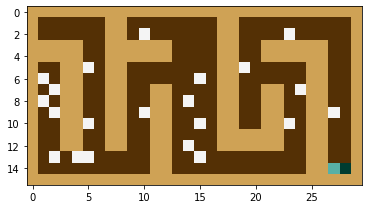

This episode took 124 timesteps and reward 96
Episode: 2001
This episode took 106 timesteps and reward 96
Episode: 2002
This episode took 686 timesteps and reward 72
Episode: 2003
This episode took 580 timesteps and reward 78
Episode: 2004
This episode took 704 timesteps and reward 60
Episode: 2005
Episode: 2006
This episode took 154 timesteps and reward 94
Episode: 2007
This episode took 587 timesteps and reward 63
Episode: 2008
This episode took 532 timesteps and reward 78
Episode: 2009
This episode took 105 timesteps and reward 93
Episode: 2010
This episode took 102 timesteps and reward 100
Episode: 2011
This episode took 167 timesteps and reward 97
Episode: 2012
This episode took 180 timesteps and reward 96
Episode: 2013
This episode took 243 timesteps and reward 85
Episode: 2014
This episode took 103 timesteps and reward 91
Episode: 2015
This episode took 114 timesteps and reward 96
Episode: 2016
This episode took 113 timesteps and reward 91
Episode: 2017
This episode took 120 tim

In [20]:
if __name__ =="__main__":
    alpha = 0.4
    gamma = 0.999
    epsilon = 0.9
    episodes = 3000
    max_steps = 1000
    n_tests = 20
    timestep_reward = sarsa(alpha, gamma, epsilon, episodes, max_steps, n_tests)
    print(timestep_reward)